In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [ ]:
class solver:
  def __init__(self, dt = 0.1, **rules):
    self.rules = rules
    self.params = rules.keys()
    self.dt = dt

  def update(self):
    self.set_to(**{name:getattr(self, name) + self.rules[name](**{name:getattr(self, name) for name in self.rules})*self.dt for name in self.rules})

  def set_to(self, **values):
    for j in values:
      setattr(self, j, values[j])

  def solve(self, t_end, t_start = 0):
    self.t = t_start
    history = {name:[] for name in self.rules}
    history['t'] = []
    while self.t < t_end:
      self.update()
      for j in history:
        history[j].append(getattr(self, j))
      self.t += self.dt
    delattr(self, 't')
    for j in history:
      history[j] = np.array(history[j])
    return history

class xwx(solver):
  def __init__(self, W, dt=0.1):
    self.W = W
    super().__init__(dt, x = lambda x: x @ self.W @ x)


In [16]:
def randomW(N):
    return np.random.uniform(-1, 1, (N, N, N)) - 100*np.eye(N)

def generate_connections(groups, group_complexity, group_density = 0.5, noise = 1, noise_density = 0.3, group_recurent_rate = 0.5):
    return \
    np.repeat(np.repeat((1-group_recurent_rate)*(np.random.sample([groups, groups]) < group_density) + group_recurent_rate*np.eye(groups, groups), group_complexity, 0), group_complexity, 1) * np.random.uniform(-1, 1, [group_complexity*groups]*2) + \
    noise * np.random.uniform(-1, 1, [group_complexity*groups]*2) * (np.random.sample([group_complexity*groups]*2) < noise_density) # skip connections

def generate_multiple_connections(C):
    N = C.shape[0]
    return (np.random.uniform(-1, 1, [N]*3)) * C

In [17]:
def generate_activity(W, t_end = 10):
    s = xwx(W, dt = 0.001)
    s.x = np.random.uniform(-1, 1, W.shape[0])
    h = s.solve(t_end)
    return h

def add_axis(a):
    return np.reshape(a, (-1, 1))

def generate_dataset(activity):
    dx_dt = (activity['x'][1:] - activity['x'][:-1]) / add_axis(activity['t'][1:] - activity['t'][:-1])
    xx = np.array([np.kron(x, x).flatten() for x in activity['x']])
    return xx[:-1], dx_dt

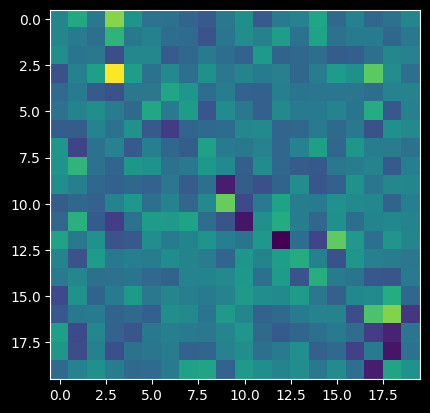

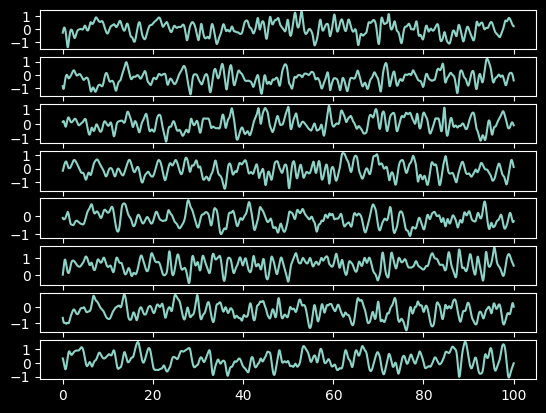

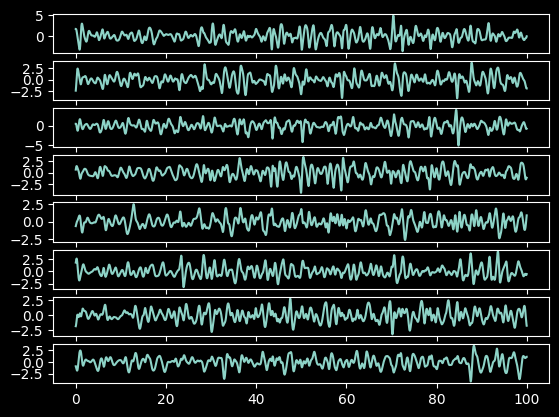

In [18]:
W = generate_connections(5, 4, group_density = 1.0, noise = 0.1, noise_density = 1.0, group_recurent_rate = 0.9)
W = generate_multiple_connections(W)
W = W - W.T
plt.imshow(W[:, :].mean(-1))
plt.show()

d = generate_activity(W, t_end= 100)

def plot_activity(d, var_count = 2):
    fig, ax = plt.subplots(var_count, 1)
    for n, i in enumerate(ax):
        i.plot(d['t'], d['x'][:, n])
    plt.show()

plot_activity(d, var_count = 8)
dataset = generate_dataset(d)
plot_activity({'t':d['t'][:-1],'x':dataset[1]}, 8)

In [19]:
from sklearn.linear_model import LinearRegression

X, y = dataset
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [20]:
np.mean((model.predict(X) - y)**2)

np.float64(1.6434336597174928e-24)

In [21]:
predicted_w = (model.coef_).reshape((20, 20, 20))

In [22]:
np.mean((predicted_w - W)**2) # <- работает :>

np.float64(0.01936439878513732)

In [23]:
predicted_w[0, 0, 0], W[0, 0, 0]

(np.float64(-1.9904904425759375e-13), np.float64(0.0))

-2.4041519806015423 1.6755917672965581


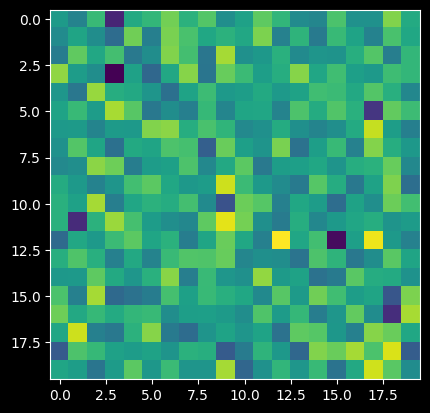

In [24]:
lenghts = np.sum(predicted_w, -1) - np.sum(W, -1)
print(lenghts.min(), lenghts.max())
plt.imshow(lenghts)
plt.show()

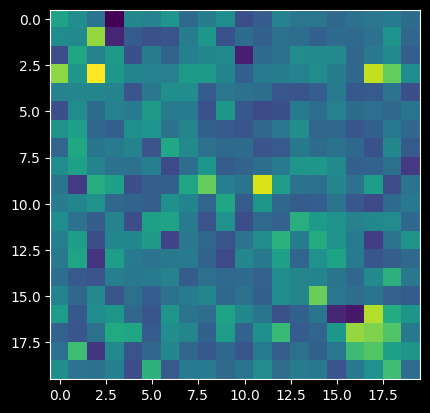

In [25]:
plt.imshow((predicted_w @ predicted_w)[:, :].sum(-1))
plt.show()

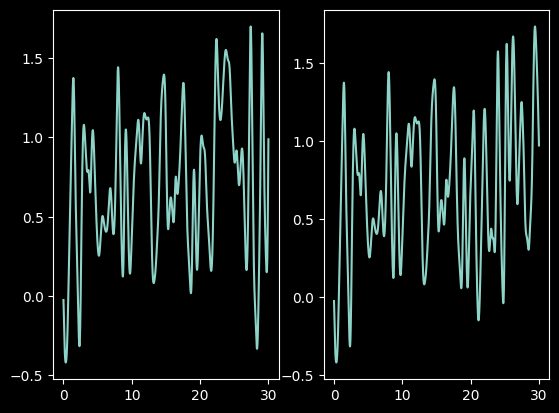

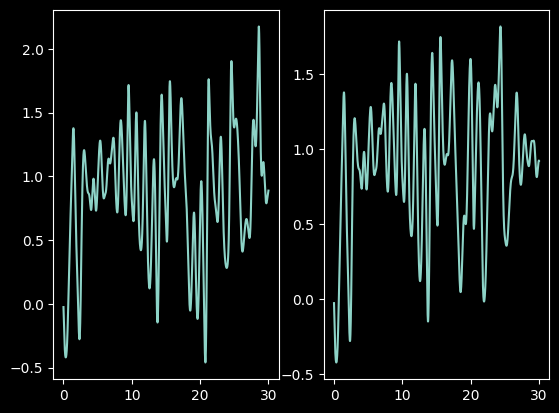

In [26]:
x0 = np.random.uniform(-1, 1, predicted_w.shape[0])

def show_dynamics(W, predicted_w, x0, dt = 0.01, T = 10):
    a = xwx(W, dt = dt)
    b = xwx(predicted_w, dt = dt)

    a.x = np.copy(x0)
    b.x = np.copy(x0)

    a_s = a.solve(T)
    b_s = b.solve(T)

    fig,ax = plt.subplots(1, 2)
    ax[0].plot(a_s['t'], a_s['x'][:, 5])
    ax[1].plot(b_s['t'], b_s['x'][:, 5])
    plt.show()

show_dynamics(W, predicted_w, x0, T = 30, dt = 0.001)
x0[0] += 0.01
show_dynamics(W, predicted_w, x0, T = 30, dt = 0.001)